# Efficient Net - Repurposing/Finetuning
## Introduction

This notebook is an attempt to repurpose and finetune an EfficientNet model to the task of American Sign Language detection for the DSPRO2 project at HSLU.

## Setup
In this section all the necessary libraries are imported.

In [1]:
%pip install -r requirements.txt -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyzstd 0.17.0 requires typing-extensions>=4.13.2; python_version < "3.13", but you have typing-extensions 4.13.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install kornia fiftyone

  Using cached typing_extensions-4.13.2-py3-none-any.whl.metadata (3.0 kB)
Using cached typing_extensions-4.13.2-py3-none-any.whl (45 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.13.1
    Uninstalling typing_extensions-4.13.1:
      Successfully uninstalled typing_extensions-4.13.1
Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch.nn as nn
import torchvision.models as visionmodels

import os

# Our own modules
import models.sweep_helper as sweep_helper


from models.asl_model import ASLModel
from models.training import sweep, train_model

In [ ]:
from datapipeline.asl_image_data_module import ASLImageDataModule
from datapipeline.asl_kaggle_image_data_module import ASLKaggleImageDataModule, DEFAULT_TRANSFORMS

In [4]:
os.environ["WANDB_NOTEBOOK_NAME"] = "./dspro2/efficientnet.ipynb"

## Preprocessing
No general data preprocessing is necessary, however there will be random transforms applied to the images during training. The images are resized to 224x224 pixels, which is the input size of the EfficientNet model. The images are also normalized using the mean and standard deviation of the ImageNet dataset, which is the dataset on which the EfficientNet model was pretrained.

The following cells will show the loading of the dataset and the preparation of the mentioned transforms.

In [5]:
PATH = "/exchange/dspro2/silent-speech/ASL_Pictures_Dataset"
PATH = r"C:\Temp\silent-speech"

In [4]:
# datamodule = ASLImageDataModule(path=PATH, val_split_folder="Validation", batch_size=32, num_workers=128)
datamodule = ASLKaggleImageDataModule(path=PATH, train_transforms=DEFAULT_TRANSFORMS.TRAIN, valid_transforms=DEFAULT_TRANSFORMS.VALID, test_transforms=DEFAULT_TRANSFORMS.TEST, batch_size=32, num_workers=20)

NameError: name 'ASLKaggleImageDataModule' is not defined

## Models

In [6]:
NUM_CLASSES = 28

In [7]:
class ASLEfficientNet(nn.Module):
    def __init__(self, efficientnet_model: visionmodels.efficientnet.EfficientNet, dropout: float = 0.2, unfreeze_features: int = 1, num_classes: int = NUM_CLASSES):
        super().__init__()
        self.model = efficientnet_model
        self.model.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(self.model.classifier[1].in_features, num_classes)
        )

        unfreeze_features = min(unfreeze_features, len(self.model.features))
        self.unfreeze_features = unfreeze_features
        self.model.features[:len(self.model.features)-unfreeze_features].requires_grad_(False)

    def forward(self, x):
        return self.model(x)

    def get_main_params(self):
        yield from self.model.classifier.parameters()

    def get_finetune_params(self):
        yield from self.model.features.parameters()

## Training

In [8]:
EFFICIENTNET_MODEL = "efficientnet_model"
DROPOUT = "dropout"

In [9]:
def get_pretrained_efficientnet_model(model_type: str):
    if model_type == "b0":
        efficientnet_model = visionmodels.efficientnet_b0(weights=visionmodels.EfficientNet_B0_Weights.DEFAULT)
    elif model_type == "b1":
        efficientnet_model = visionmodels.efficientnet_b1(weights=visionmodels.EfficientNet_B1_Weights.DEFAULT)
    elif model_type == "b2":
        efficientnet_model = visionmodels.efficientnet_b2(weights=visionmodels.EfficientNet_B2_Weights.DEFAULT)
    elif model_type == "b3":
        efficientnet_model = visionmodels.efficientnet_b3(weights=visionmodels.EfficientNet_B3_Weights.DEFAULT)
    elif model_type == "b4":
        efficientnet_model = visionmodels.efficientnet_b4(weights=visionmodels.EfficientNet_B4_Weights.DEFAULT)
    elif model_type == "b5":
        efficientnet_model = visionmodels.efficientnet_b5(weights=visionmodels.EfficientNet_B5_Weights.DEFAULT)
    elif model_type == "b6":
        efficientnet_model = visionmodels.efficientnet_b6(weights=visionmodels.EfficientNet_B6_Weights.DEFAULT)
    elif model_type == "b7":
        efficientnet_model = visionmodels.efficientnet_b7(weights=visionmodels.EfficientNet_B7_Weights.DEFAULT)
    elif model_type == "v2-s":
        efficientnet_model = visionmodels.efficientnet_v2_s(weights=visionmodels.EfficientNet_V2_S_Weights.DEFAULT)
    elif model_type == "v2-m":
        efficientnet_model = visionmodels.efficientnet_v2_m(weights=visionmodels.EfficientNet_V2_M_Weights.DEFAULT)
    elif model_type == "v2-l":
        efficientnet_model = visionmodels.efficientnet_v2_l(weights=visionmodels.EfficientNet_V2_L_Weights.DEFAULT)

    return efficientnet_model

In [10]:
UNFREEZE_FEATURES = "unfreeze_features"


def get_asl_efficientnet_model(efficientnet_model: visionmodels.efficientnet.EfficientNet, dropout: float, unfreeze_features: int = 0) -> nn.Module:
    return ASLEfficientNet(efficientnet_model, dropout=dropout, unfreeze_features=unfreeze_features)

In [11]:
def get_efficientnet_model_from_config(config: dict) -> nn.Module:
    efficientnet_model = get_pretrained_efficientnet_model(config[EFFICIENTNET_MODEL])
    model = get_asl_efficientnet_model(efficientnet_model, config[DROPOUT], config[UNFREEZE_FEATURES])
    return model

In [12]:
run_id = 0
SEED = 42


def train_efficient_net():
    train_model("efficientnet", get_efficientnet_model_from_config, datamodule, get_optimizer=sweep_helper.get_optimizer_with_finetune_group, seed=SEED)

In [13]:
sweep_config = {
    "name": "EfficientNet-V2-S",
    "method": "bayes",
    "metric": {
        "name": f"{ASLModel.VALID_ACCURACY}",
        "goal": "maximize"
    },
    "early_terminate": {
        "type": "hyperband",
        "min_iter": 5
    },
    "parameters": {
        EFFICIENTNET_MODEL: {
            "value": "v2-s"
        },
        UNFREEZE_FEATURES: {
           "value": 1
        },
        DROPOUT: {
            "min": 0.1,
            "max": 0.5
        },
        sweep_helper.OPTIMIZER: {
            "parameters": {
                sweep_helper.TYPE: {
                    "value": sweep_helper.OptimizerType.RMSPROP
                },
                sweep_helper.LEARNING_RATE: {
                    "min": 1e-5,
                    "max": 1e-3,
                    "distribution": "log_uniform_values"
                },
                sweep_helper.FINETUNE_LEARNING_RATE: {
                    "min": 1e-7,
                    "max": 1e-5,
                    "distribution": "log_uniform_values"
                },
                sweep_helper.WEIGHT_DECAY: {
                    "min": 0,
                    "max": 1e-3,
                },
                sweep_helper.MOMENTUM: {
                    "min": 0.8,
                    "max": 0.99
                }
            }
        },
        sweep_helper.LEARNING_RATE_SCHEDULER: {
             "parameters": {
                sweep_helper.TYPE: {
                    "values": [sweep_helper.LearningRateSchedulerType.STEP, sweep_helper.LearningRateSchedulerType.EXPONENTIAL]
                },
                sweep_helper.STEP_SIZE: {"value": 5},
                sweep_helper.GAMMA: {
                    "min": 0.1,
                    "max": 0.9
                }
            }
        }
    }
}

In [ ]:
sweep(sweep_config=sweep_config, count=20, training_procedure=train_efficient_net)

In [13]:
finetune_sweep_config_b0 = {
    "name": "EfficientNet-B0-Finetune",
    "method": "bayes",
    "metric": {
        "name": f"{ASLModel.VALID_ACCURACY}",
        "goal": "maximize"
    },
    "early_terminate": {
        "type": "hyperband",
        "min_iter": 5
    },
    "parameters": {
        EFFICIENTNET_MODEL: {
            "value": "b0"
        },
        UNFREEZE_FEATURES: {
            "min": 1,
            "max": 9
        },
        DROPOUT: {
            "min": 0.1,
            "max": 0.5
        },
        sweep_helper.OPTIMIZER: {
            "parameters": {
                sweep_helper.TYPE: {
                    "value": sweep_helper.OptimizerType.RMSPROP
                },
                sweep_helper.LEARNING_RATE: {
                    "min": 1e-5,
                    "max": 1e-2,
                    "distribution": "log_uniform_values"
                },
                sweep_helper.WEIGHT_DECAY: {
                    "min": 0,
                    "max": 1e-3,
                },
                sweep_helper.MOMENTUM: {
                    "min": 0.8,
                    "max": 0.99
                }
            }
        },
        sweep_helper.LEARNING_RATE_SCHEDULER: {
            "parameters": {
                sweep_helper.TYPE: {
                    "values": [sweep_helper.LearningRateSchedulerType.NONE, sweep_helper.LearningRateSchedulerType.STEP, sweep_helper.LearningRateSchedulerType.EXPONENTIAL]
                },
                sweep_helper.STEP_SIZE: {
                    "min": 1,
                    "max": 10
                },
                sweep_helper.GAMMA: {
                    "min": 0.1,
                    "max": 0.9
                }
            }
        }
    }
}

NameError: name 'TUNE_TYPE' is not defined

In [ ]:
sweep(sweep_config=finetune_sweep_config_b0, count=30, training_procedure=train_efficient_net)

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find ./dspro2/efficientnet.ipynb.


Create sweep with ID: da3s4woi
Sweep URL: https://wandb.ai/dspro2-silent-speech/silent-speech/sweeps/da3s4woi


wandb: Agent Starting Run: 5ya04w7r with config:
wandb: 	dropout: 0.4882254824597369
wandb: 	efficientnet_model: b0
wandb: 	learning_rate_scheduler: {'gamma': 0.12207377267316807, 'step_size': 8, 'type': 'exponential'}
wandb: 	optimizer: {'learning_rate': 0.00014626705462299463, 'momentum': 0.9600000119859484, 'type': 'rmsprop', 'weight_decay': 0.0003786203337267541}
wandb: 	tune_type: finetune
wandb: 	unfreeze_features: 2
Seed set to 42
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find ./dspro2/efficientnet.ipynb.
wandb: Currently logged in as: v8-luky (dspro2-silent-speech) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A16') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                    | Params | Mode 
-------------------------------------------------------------------
0 | model          | ASLEfficientNetFinetune | 4.0 M  | train
1 | criterion 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.990
Metric train_accuracy improved. New best score: 0.946


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.006 >= min_delta = 0.0. New best score: 0.996
Metric train_accuracy improved by 0.042 >= min_delta = 0.0. New best score: 0.989


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.996
Metric train_accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.993


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.996
Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.993


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.993


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.997


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric train_accuracy did not improve in the last 5 records. Best score: 0.993. Signaling Trainer to stop.


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██
lr-RMSprop,█████▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-RMSprop-momentum,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-RMSprop-weight_decay,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy_epoch,▁▇████████
train_accuracy_step,▁▂▇▇▅▄█████▇▇▇██▇███████▇███▇███▇█▇███▇█
train_loss_epoch,█▂▁▁▁▁▁▁▁▁
train_loss_step,▅█▃▂▄▁▂▁▂▁▁▁▁▂▁▁▂▁▃▃▁▁▂▂▂▁▄▁▁▁▂▁▂▁▂▂▁▁▂▁
trainer/global_step,▁▁▁▁▁▃▂▂▂▂▂▅▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃█▃▄▄▄▄▄
valid_accuracy_epoch,▁▇▇▇▇█▇▆▆█
valid_accuracy_step,██████▁██▁▁█████████▁█▁█▁███████████▁███


wandb: Agent Starting Run: p7v8q4nc with config:
wandb: 	dropout: 0.2827040182453778
wandb: 	efficientnet_model: b0
wandb: 	learning_rate_scheduler: {'gamma': 0.5596732515653552, 'step_size': 4, 'type': 'none'}
wandb: 	optimizer: {'learning_rate': 7.800980168851934e-05, 'momentum': 0.8940542066814777, 'type': 'rmsprop', 'weight_decay': 0.0004635554431632722}
wandb: 	tune_type: finetune
wandb: 	unfreeze_features: 3
Seed set to 42
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find ./dspro2/efficientnet.ipynb.


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                    | Params | Mode 
-------------------------------------------------------------------
0 | model          | ASLEfficientNetFinetune | 4.0 M  | train
1 | criterion      | CrossEntropyLoss        | 0      | train
2 | train_accuracy | MulticlassAccuracy      | 0      | train
3 | valid_accuracy | MulticlassAccuracy      | 0      | train
4 | test_accuracy  | MulticlassAccuracy      | 0      | train
-------------------------------------------------------------------
3.2 M     Trainable params
851 K     Non-trainabl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.987
Metric train_accuracy improved. New best score: 0.979


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.009 >= min_delta = 0.0. New best score: 0.996
Metric train_accuracy improved by 0.015 >= min_delta = 0.0. New best score: 0.994


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.997
Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.994


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.997
Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.995


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.998
Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.995


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.998


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.996


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.996


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.998. Signaling Trainer to stop.
Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.996


epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
lr-RMSprop,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-RMSprop-momentum,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-RMSprop-weight_decay,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy_epoch,▁▇▇████████
train_accuracy_step,▁▅███▅████▅█████████████▅▅██▅███████████
train_loss_epoch,█▂▂▂▁▁▁▁▁▁▁
train_loss_step,▆▂▁▄▃▁▁▁▂▂▂█▁▂▂▂▂▂▁▁▂▂▁▂▂▃▂▁▂▂▃▄▄▃▂▃▅▄▂▂
trainer/global_step,▁▁▁▁▁▁▁▁▁▁▂▃▂▂▂▂▂▂▂▂▅▂▂▂▂▂▃▃▃▃▃▃▃▃▃██▃▃▃
valid_accuracy_epoch,▁▇▇▇██▇▇▇█▇
valid_accuracy_step,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: d718htxj with config:
wandb: 	dropout: 0.171572991544872
wandb: 	efficientnet_model: b0
wandb: 	learning_rate_scheduler: {'gamma': 0.23042224803407785, 'step_size': 3, 'type': 'exponential'}
wandb: 	optimizer: {'learning_rate': 0.0006703235551518386, 'momentum': 0.8568555153832116, 'type': 'rmsprop', 'weight_decay': 0.00018206585619814596}
wandb: 	tune_type: finetune
wandb: 	unfreeze_features: 8
Seed set to 42
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find ./dspro2/efficientnet.ipynb.


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                    | Params | Mode 
-------------------------------------------------------------------
0 | model          | ASLEfficientNetFinetune | 4.0 M  | train
1 | criterion      | CrossEntropyLoss        | 0      | train
2 | train_accuracy | MulticlassAccuracy      | 0      | train
3 | valid_accuracy | MulticlassAccuracy      | 0      | train
4 | test_accuracy  | MulticlassAccuracy      | 0      | train
-------------------------------------------------------------------
4.0 M     Trainable params
928       Non-trainabl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.970
Metric train_accuracy improved. New best score: 0.905


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.026 >= min_delta = 0.0. New best score: 0.997
Metric train_accuracy improved by 0.091 >= min_delta = 0.0. New best score: 0.996


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.999
Metric train_accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.998


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 1.000
Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.999


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 1.000
Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.999


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 1.000
Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.999


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 1.000
Monitored metric train_accuracy did not improve in the last 5 records. Best score: 0.999. Signaling Trainer to stop.


epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█
lr-RMSprop,█████▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-RMSprop-momentum,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-RMSprop-weight_decay,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy_epoch,▁██████████
train_accuracy_step,▁████▇██▇███████▇██████████████████▇██▇█
train_loss_epoch,█▁▁▁▁▁▁▁▁▁▁
train_loss_step,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▂▄▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃█▃▃▃▃▃▃▃▄▄▄▄
valid_accuracy_epoch,▁▇█████████
valid_accuracy_step,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: d018tdx6 with config:
wandb: 	dropout: 0.4391321561240148
wandb: 	efficientnet_model: b0
wandb: 	learning_rate_scheduler: {'gamma': 0.21204549660809668, 'step_size': 5, 'type': 'step'}
wandb: 	optimizer: {'learning_rate': 0.008411968198193719, 'momentum': 0.8349173493479937, 'type': 'rmsprop', 'weight_decay': 0.0008021813311850058}
wandb: 	tune_type: finetune
wandb: 	unfreeze_features: 5
Seed set to 42
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find ./dspro2/efficientnet.ipynb.


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                    | Params | Mode 
-------------------------------------------------------------------
0 | model          | ASLEfficientNetFinetune | 4.0 M  | train
1 | criterion      | CrossEntropyLoss        | 0      | train
2 | train_accuracy | MulticlassAccuracy      | 0      | train
3 | valid_accuracy | MulticlassAccuracy      | 0      | train
4 | test_accuracy  | MulticlassAccuracy      | 0      | train
-------------------------------------------------------------------
4.0 M     Trainable params
65.7 K    Non-trainabl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.032
Metric train_accuracy improved. New best score: 0.573


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.091 >= min_delta = 0.0. New best score: 0.124
Metric train_accuracy improved by 0.133 >= min_delta = 0.0. New best score: 0.706


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.016 >= min_delta = 0.0. New best score: 0.722


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.006 >= min_delta = 0.0. New best score: 0.728


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.730 >= min_delta = 0.0. New best score: 0.853
Metric train_accuracy improved by 0.187 >= min_delta = 0.0. New best score: 0.915


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.009 >= min_delta = 0.0. New best score: 0.924


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.005 >= min_delta = 0.0. New best score: 0.928


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.930


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.930


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.129 >= min_delta = 0.0. New best score: 0.982
Metric train_accuracy improved by 0.043 >= min_delta = 0.0. New best score: 0.973


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.006 >= min_delta = 0.0. New best score: 0.988
Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.974


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.989
Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.975


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.975


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.006 >= min_delta = 0.0. New best score: 0.995
Metric train_accuracy improved by 0.010 >= min_delta = 0.0. New best score: 0.985


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.986


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.986


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.986


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.986


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.995
Metric train_accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.988


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.996
Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.989


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.989


Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.996. Signaling Trainer to stop.
Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.990


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
lr-RMSprop,█████████▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-RMSprop-momentum,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-RMSprop-weight_decay,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy_epoch,▁▃▃▃▄▇▇▇▇▇█████████████████
train_accuracy_step,▄▄▂▁▂▃▆▃▅█▇▆▆▇▇▆▇▇▇▇██▇██▇█▇▇█▇███▇█████
train_loss_epoch,█▅▅▅▅▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,▅▆▆██▄▃▂▅▇▇▃▁▂▂▂▄▂▁▁▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▁▁▃▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▇▇█████
valid_accuracy_epoch,▁▂▂▁▁▇▆▆▇▆█████████████████
valid_accuracy_step,▁▁▁▁▁▁▃▇▅█▅▇▁▅█▅████████████████████████


wandb: Agent Starting Run: vebgisjc with config:
wandb: 	dropout: 0.23339073443675645
wandb: 	efficientnet_model: b0
wandb: 	learning_rate_scheduler: {'gamma': 0.530506901490113, 'step_size': 6, 'type': 'step'}
wandb: 	optimizer: {'learning_rate': 0.0006408095360303812, 'momentum': 0.8990830296219949, 'type': 'rmsprop', 'weight_decay': 0.00013017658405344235}
wandb: 	tune_type: finetune
wandb: 	unfreeze_features: 1
Seed set to 42
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find ./dspro2/efficientnet.ipynb.


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                    | Params | Mode 
-------------------------------------------------------------------
0 | model          | ASLEfficientNetFinetune | 4.0 M  | train
1 | criterion      | CrossEntropyLoss        | 0      | train
2 | train_accuracy | MulticlassAccuracy      | 0      | train
3 | valid_accuracy | MulticlassAccuracy      | 0      | train
4 | test_accuracy  | MulticlassAccuracy      | 0      | train
-------------------------------------------------------------------
448 K     Trainable params
3.6 M     Non-trainabl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.938
Metric train_accuracy improved. New best score: 0.880


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.006 >= min_delta = 0.0. New best score: 0.944
Metric train_accuracy improved by 0.021 >= min_delta = 0.0. New best score: 0.901


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.009 >= min_delta = 0.0. New best score: 0.953
Metric train_accuracy improved by 0.010 >= min_delta = 0.0. New best score: 0.911


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.008 >= min_delta = 0.0. New best score: 0.960
Metric train_accuracy improved by 0.006 >= min_delta = 0.0. New best score: 0.916


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.920


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.922


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.011 >= min_delta = 0.0. New best score: 0.971
Metric train_accuracy improved by 0.017 >= min_delta = 0.0. New best score: 0.939


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.939


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.940


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.974


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.976
Metric train_accuracy improved by 0.011 >= min_delta = 0.0. New best score: 0.951


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.979


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.980
Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.951


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.984
Metric train_accuracy improved by 0.006 >= min_delta = 0.0. New best score: 0.957


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.958


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.984. Signaling Trainer to stop.


epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇█████
lr-RMSprop,██████████▄▄▄▄▄▄▄▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
lr-RMSprop-momentum,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-RMSprop-weight_decay,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy_epoch,▁▃▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇██████
train_accuracy_step,▁▂▆▇▇▇▆▅▆▇▇▆█▆▆▆█▇▇▇▇▇▆▆▇█▇█▆█▇█▆▇█▇█▃█▇
train_loss_epoch,█▆▅▄▄▄▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
train_loss_step,▅▅▅▆▄▆▂▅▂▂█▅▃▃▂▂▄▄▂▃▃▃▃▃▃▂▄▂▂▂▂▂▅▂▂▃▁▁▂▂
trainer/global_step,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃█▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅
valid_accuracy_epoch,▁▂▃▄▃▄▆▆▅▆▇▆▇▇▇▇▇▇██████
valid_accuracy_step,▆█▆██▆█▃▆██▅▁▆▃███████▅▆███▅█▅██▆█▆██▅██


wandb: Agent Starting Run: 13yz8fm1 with config:
wandb: 	dropout: 0.456025135932436
wandb: 	efficientnet_model: b0
wandb: 	learning_rate_scheduler: {'gamma': 0.7322270203412483, 'step_size': 5, 'type': 'exponential'}
wandb: 	optimizer: {'learning_rate': 0.001934971585009851, 'momentum': 0.9502296967426715, 'type': 'rmsprop', 'weight_decay': 0.0005678329957698574}
wandb: 	tune_type: finetune
wandb: 	unfreeze_features: 7
Seed set to 42
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find ./dspro2/efficientnet.ipynb.


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                    | Params | Mode 
-------------------------------------------------------------------
0 | model          | ASLEfficientNetFinetune | 4.0 M  | train
1 | criterion      | CrossEntropyLoss        | 0      | train
2 | train_accuracy | MulticlassAccuracy      | 0      | train
3 | valid_accuracy | MulticlassAccuracy      | 0      | train
4 | test_accuracy  | MulticlassAccuracy      | 0      | train
-------------------------------------------------------------------
4.0 M     Trainable params
2.4 K     Non-trainabl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.474
Metric train_accuracy improved. New best score: 0.564


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.219 >= min_delta = 0.0. New best score: 0.783


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.291 >= min_delta = 0.0. New best score: 0.765
Metric train_accuracy improved by 0.064 >= min_delta = 0.0. New best score: 0.847


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.109 >= min_delta = 0.0. New best score: 0.874
Metric train_accuracy improved by 0.044 >= min_delta = 0.0. New best score: 0.891


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.068 >= min_delta = 0.0. New best score: 0.942
Metric train_accuracy improved by 0.024 >= min_delta = 0.0. New best score: 0.915


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.019 >= min_delta = 0.0. New best score: 0.933


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.007 >= min_delta = 0.0. New best score: 0.949
Metric train_accuracy improved by 0.013 >= min_delta = 0.0. New best score: 0.947


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.030 >= min_delta = 0.0. New best score: 0.979
Metric train_accuracy improved by 0.011 >= min_delta = 0.0. New best score: 0.957


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.007 >= min_delta = 0.0. New best score: 0.964


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.983
Metric train_accuracy improved by 0.007 >= min_delta = 0.0. New best score: 0.971


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.987
Metric train_accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.974


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.977


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.005 >= min_delta = 0.0. New best score: 0.992
Metric train_accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.980


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.982


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.993
Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.983


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.994
Metric train_accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.984


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.994
Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.984


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.995
Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.985


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.985


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.986


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.995


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.987


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.996
Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.987


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.987


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.988


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.988


Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.996. Signaling Trainer to stop.


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
lr-RMSprop,██▆▆▆▆▅▅▅▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-RMSprop-momentum,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-RMSprop-weight_decay,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy_epoch,▁▅▆▆▇▇▇▇███████████████████████
train_accuracy_step,▁▅▆▇▆█▆▇▆▇▅█▇█▇█▇█████████████████████▇█
train_loss_epoch,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,▇█▄▄▄▂▄▂▃▂▃▁▂▂▂▂▁▂▁▂▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▂▂▂▁▂
trainer/global_step,▁▁▁▁▁▁▁▁▁▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▇▃▃▃█▃▄▄▄▄▄
valid_accuracy_epoch,▃▁▆▇▇▇█████████████████████████
valid_accuracy_step,▄▁▁▁▃▇▇█████████████████████████████████


wandb: Agent Starting Run: i2ilje69 with config:
wandb: 	dropout: 0.46981312864807856
wandb: 	efficientnet_model: b0
wandb: 	learning_rate_scheduler: {'gamma': 0.4627695870643297, 'step_size': 1, 'type': 'exponential'}
wandb: 	optimizer: {'learning_rate': 0.007344716952576528, 'momentum': 0.9208484078094272, 'type': 'rmsprop', 'weight_decay': 0.0007022773592173798}
wandb: 	tune_type: finetune
wandb: 	unfreeze_features: 3
Seed set to 42
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find ./dspro2/efficientnet.ipynb.


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                    | Params | Mode 
-------------------------------------------------------------------
0 | model          | ASLEfficientNetFinetune | 4.0 M  | train
1 | criterion      | CrossEntropyLoss        | 0      | train
2 | train_accuracy | MulticlassAccuracy      | 0      | train
3 | valid_accuracy | MulticlassAccuracy      | 0      | train
4 | test_accuracy  | MulticlassAccuracy      | 0      | train
-------------------------------------------------------------------
3.2 M     Trainable params
851 K     Non-trainabl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.457
Metric train_accuracy improved. New best score: 0.521


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.291 >= min_delta = 0.0. New best score: 0.812


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.411 >= min_delta = 0.0. New best score: 0.868
Metric train_accuracy improved by 0.093 >= min_delta = 0.0. New best score: 0.905


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.077 >= min_delta = 0.0. New best score: 0.945
Metric train_accuracy improved by 0.038 >= min_delta = 0.0. New best score: 0.943


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.039 >= min_delta = 0.0. New best score: 0.984
Metric train_accuracy improved by 0.019 >= min_delta = 0.0. New best score: 0.962


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.007 >= min_delta = 0.0. New best score: 0.991
Metric train_accuracy improved by 0.011 >= min_delta = 0.0. New best score: 0.974


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.993
Metric train_accuracy improved by 0.005 >= min_delta = 0.0. New best score: 0.979


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.982


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.983


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.994
Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.984


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.995


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.984


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.985


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.995


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric train_accuracy did not improve in the last 5 records. Best score: 0.985. Signaling Trainer to stop.


epoch,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▆▆▆▆▇▇▇▇█████
lr-RMSprop,███▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-RMSprop-momentum,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-RMSprop-weight_decay,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy_epoch,▁▅▇▇██████████████
train_accuracy_step,▄▁▇▃▆▆▇▆▆▆▇▇█▇▇███▇██████████▇██████████
train_loss_epoch,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,█▇▄▂▃▂▂▂▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▃▁▂▂▂▃▂▂▂▂▂▂▃▃▃▃▃▃▃█▃▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅
valid_accuracy_epoch,▃▁▇███████████████
valid_accuracy_step,▄▄▁▁▁▅▇▁█▇██████████████████████████████


wandb: Agent Starting Run: lxgzbt8w with config:
wandb: 	dropout: 0.17892983860079897
wandb: 	efficientnet_model: b0
wandb: 	learning_rate_scheduler: {'gamma': 0.6360402088083317, 'step_size': 7, 'type': 'step'}
wandb: 	optimizer: {'learning_rate': 0.0018558748422814629, 'momentum': 0.8209211561768747, 'type': 'rmsprop', 'weight_decay': 0.0006948023427309001}
wandb: 	tune_type: finetune
wandb: 	unfreeze_features: 9
Seed set to 42
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find ./dspro2/efficientnet.ipynb.


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                    | Params | Mode 
-------------------------------------------------------------------
0 | model          | ASLEfficientNetFinetune | 4.0 M  | train
1 | criterion      | CrossEntropyLoss        | 0      | train
2 | train_accuracy | MulticlassAccuracy      | 0      | train
3 | valid_accuracy | MulticlassAccuracy      | 0      | train
4 | test_accuracy  | MulticlassAccuracy      | 0      | train
-------------------------------------------------------------------
4.0 M     Trainable params
0         Non-trainabl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.788
Metric train_accuracy improved. New best score: 0.620


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.275 >= min_delta = 0.0. New best score: 0.896


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.019 >= min_delta = 0.0. New best score: 0.915


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.009 >= min_delta = 0.0. New best score: 0.925


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.928


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.076 >= min_delta = 0.0. New best score: 0.865
Metric train_accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.932


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.935


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.015 >= min_delta = 0.0. New best score: 0.880
Metric train_accuracy improved by 0.021 >= min_delta = 0.0. New best score: 0.956


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.959


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.071 >= min_delta = 0.0. New best score: 0.950
Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.959


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.961


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.013 >= min_delta = 0.0. New best score: 0.974


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.974


Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.950. Signaling Trainer to stop.


epoch,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
lr-RMSprop,███████████████▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▁▁▁▁▁▁▁▁
lr-RMSprop-momentum,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-RMSprop-weight_decay,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy_epoch,▁▆▇▇▇▇▇██████████
train_accuracy_step,▁▅▄▆▆█▆▇▇█▇▆▆▇▇▇▇▆█▇▆█▇▇▇▆▇▇▆█▇▇█▇▇▇██▆█
train_loss_epoch,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train_loss_step,██▄▇▅▅▄▆▃▅▂▂▂▂▄▁▃▃▂▂▂▁▁▂▂▂▂▂▂▁▁▂▁▂▂▁▃▂▁▂
trainer/global_step,▁▁▁▁▁▃▂▂▂▂▃▃▃▃▃▃█▃▃▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆
valid_accuracy_epoch,▅▅▅▃▄▆▁▇▄▆▇█▇█▇█▆
valid_accuracy_step,▆▃█▃▇▇▆▇▁█▆██▇▇▇▅█▇██▇▆███▆████▆██▅▇▅██▇


wandb: Agent Starting Run: dkvet634 with config:
wandb: 	dropout: 0.2939092231094789
wandb: 	efficientnet_model: b0
wandb: 	learning_rate_scheduler: {'gamma': 0.2101677981851049, 'step_size': 8, 'type': 'step'}
wandb: 	optimizer: {'learning_rate': 0.0006928978271860535, 'momentum': 0.9665470526096438, 'type': 'rmsprop', 'weight_decay': 0.0008721733194581569}
wandb: 	tune_type: finetune
wandb: 	unfreeze_features: 7
Seed set to 42
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find ./dspro2/efficientnet.ipynb.


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                    | Params | Mode 
-------------------------------------------------------------------
0 | model          | ASLEfficientNetFinetune | 4.0 M  | train
1 | criterion      | CrossEntropyLoss        | 0      | train
2 | train_accuracy | MulticlassAccuracy      | 0      | train
3 | valid_accuracy | MulticlassAccuracy      | 0      | train
4 | test_accuracy  | MulticlassAccuracy      | 0      | train
-------------------------------------------------------------------
4.0 M     Trainable params
2.4 K     Non-trainabl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.755
Metric train_accuracy improved. New best score: 0.754


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.114 >= min_delta = 0.0. New best score: 0.867


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.014 >= min_delta = 0.0. New best score: 0.881


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.013 >= min_delta = 0.0. New best score: 0.895


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.044 >= min_delta = 0.0. New best score: 0.800
Metric train_accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.898


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.042 >= min_delta = 0.0. New best score: 0.842


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.134 >= min_delta = 0.0. New best score: 0.976
Metric train_accuracy improved by 0.068 >= min_delta = 0.0. New best score: 0.966


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.978


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.008 >= min_delta = 0.0. New best score: 0.985


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.967


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.989
Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.968


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.005 >= min_delta = 0.0. New best score: 0.995
Metric train_accuracy improved by 0.018 >= min_delta = 0.0. New best score: 0.985


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.995. Signaling Trainer to stop.
Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.985


epoch,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██
lr-RMSprop,██████████▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
lr-RMSprop-momentum,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-RMSprop-weight_decay,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy_epoch,▁▄▅▅▅▅▅▅▇▇▇▇▇▇▇▇██████
train_accuracy_step,▅▁▂▅▁▇▁▁▅▇▂▄███▅█▅█▇█▇▅▄███▇███▇███▅██▇▅
train_loss_epoch,█▅▄▄▄▄▄▄▂▂▂▂▂▂▂▂▁▁▁▁▁▁
train_loss_step,█▃▃▂▃▃▂▂▃▂▂▄▃▂▃▃▃▂▁▂▁▁▁▃▂▃▁▁▁▁▁▁▁▃▁▁▁▁▁▂
trainer/global_step,▁▁▁▁▁▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
valid_accuracy_epoch,▅▄▁▄▄▆▆▅██████████████
valid_accuracy_step,▄▃██▁██▁▁▄▂▅██▇████▆█████████▆████▇█████


wandb: Agent Starting Run: zxivm626 with config:
wandb: 	dropout: 0.18338746136994288
wandb: 	efficientnet_model: b0
wandb: 	learning_rate_scheduler: {'gamma': 0.456455930661013, 'step_size': 10, 'type': 'exponential'}
wandb: 	optimizer: {'learning_rate': 0.0006927948211450823, 'momentum': 0.8759142021148976, 'type': 'rmsprop', 'weight_decay': 0.0006038833872824889}
wandb: 	tune_type: finetune
wandb: 	unfreeze_features: 2
Seed set to 42
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find ./dspro2/efficientnet.ipynb.


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                    | Params | Mode 
-------------------------------------------------------------------
0 | model          | ASLEfficientNetFinetune | 4.0 M  | train
1 | criterion      | CrossEntropyLoss        | 0      | train
2 | train_accuracy | MulticlassAccuracy      | 0      | train
3 | valid_accuracy | MulticlassAccuracy      | 0      | train
4 | test_accuracy  | MulticlassAccuracy      | 0      | train
-------------------------------------------------------------------
1.2 M     Trainable params
2.9 M     Non-trainabl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.983
Metric train_accuracy improved. New best score: 0.939


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.006 >= min_delta = 0.0. New best score: 0.989
Metric train_accuracy improved by 0.040 >= min_delta = 0.0. New best score: 0.978


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.005 >= min_delta = 0.0. New best score: 0.994
Metric train_accuracy improved by 0.008 >= min_delta = 0.0. New best score: 0.987


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.996
Metric train_accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.989


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.992


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.997
Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.993


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.993


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.993


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.997. Signaling Trainer to stop.
Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.994


epoch,▁▁▁▂▂▂▂▂▂▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█
lr-RMSprop,█████▄▄▄▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-RMSprop-momentum,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-RMSprop-weight_decay,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy_epoch,▁▆▇▇███████
train_accuracy_step,▁▇▇▇█▇▇▇█▇█▇██▇▇▇█▇██▇▇██▇█▇▇▇█▇█████▇██
train_loss_epoch,█▃▂▂▁▁▁▁▁▁▁
train_loss_step,▆▇█▃▂▃▄▂▄▂▂▁▄▁▃▁▂▁▁▂▂▂▁▄▃▁▂▂▂▂▂▁▃▁▂▂▂▂▂▂
trainer/global_step,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇██
valid_accuracy_epoch,▁▄▇▇▇██▇▇██
valid_accuracy_step,▁█▁█████████████▁███████████▁███████▁███


wandb: Agent Starting Run: evejkeyv with config:
wandb: 	dropout: 0.4275002958480669
wandb: 	efficientnet_model: b0
wandb: 	learning_rate_scheduler: {'gamma': 0.7369320435942147, 'step_size': 10, 'type': 'exponential'}
wandb: 	optimizer: {'learning_rate': 3.356341288625789e-05, 'momentum': 0.9366700950529528, 'type': 'rmsprop', 'weight_decay': 0.00020213363668489348}
wandb: 	tune_type: finetune
wandb: 	unfreeze_features: 3
Seed set to 42
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find ./dspro2/efficientnet.ipynb.


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                    | Params | Mode 
-------------------------------------------------------------------
0 | model          | ASLEfficientNetFinetune | 4.0 M  | train
1 | criterion      | CrossEntropyLoss        | 0      | train
2 | train_accuracy | MulticlassAccuracy      | 0      | train
3 | valid_accuracy | MulticlassAccuracy      | 0      | train
4 | test_accuracy  | MulticlassAccuracy      | 0      | train
-------------------------------------------------------------------
3.2 M     Trainable params
851 K     Non-trainabl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.996
Metric train_accuracy improved. New best score: 0.980


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.998
Metric train_accuracy improved by 0.016 >= min_delta = 0.0. New best score: 0.996


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.998
Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.997


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.998
Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.998


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.999


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.999


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.999


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.999


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.999


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.999. Signaling Trainer to stop.
Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 1.000


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇▇█████
lr-RMSprop,████▆▆▆▆▆▅▅▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
lr-RMSprop-momentum,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-RMSprop-weight_decay,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy_epoch,▁▇▇████████
train_accuracy_step,▁██▅████████████████████████████████████
train_loss_epoch,█▂▂▂▁▁▁▁▁▁▁
train_loss_step,█▂▁▇▂▁▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▂▂▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇████
valid_accuracy_epoch,▁▅▆▇▆█▇▆▆▇█
valid_accuracy_step,███████████████████████████▁████████████


wandb: Agent Starting Run: mj73hbsv with config:
wandb: 	dropout: 0.25303456739194297
wandb: 	efficientnet_model: b0
wandb: 	learning_rate_scheduler: {'gamma': 0.4845910816463759, 'step_size': 9, 'type': 'step'}
wandb: 	optimizer: {'learning_rate': 0.004685018723107468, 'momentum': 0.9131345929471766, 'type': 'rmsprop', 'weight_decay': 7.976551765902062e-05}
wandb: 	tune_type: finetune
wandb: 	unfreeze_features: 2
Seed set to 42
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find ./dspro2/efficientnet.ipynb.


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                    | Params | Mode 
-------------------------------------------------------------------
0 | model          | ASLEfficientNetFinetune | 4.0 M  | train
1 | criterion      | CrossEntropyLoss        | 0      | train
2 | train_accuracy | MulticlassAccuracy      | 0      | train
3 | valid_accuracy | MulticlassAccuracy      | 0      | train
4 | test_accuracy  | MulticlassAccuracy      | 0      | train
-------------------------------------------------------------------
1.2 M     Trainable params
2.9 M     Non-trainabl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.843
Metric train_accuracy improved. New best score: 0.831


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.042 >= min_delta = 0.0. New best score: 0.885
Metric train_accuracy improved by 0.037 >= min_delta = 0.0. New best score: 0.868


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.028 >= min_delta = 0.0. New best score: 0.913


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.870


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.006 >= min_delta = 0.0. New best score: 0.876


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.913. Signaling Trainer to stop.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇███████
lr-RMSprop,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-RMSprop-momentum,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-RMSprop-weight_decay,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy_epoch,▁▇▆▇██▇▇
train_accuracy_step,▁▅▄▄▆▇▄▆▅▅▃▄▅▇▅▆▅▇▆▇▅▅▄▂▄▅▆▇▅█▁▇▂▆▇▅▅▅▆▆
train_loss_epoch,█▄▃▂▁▁▁▁
train_loss_step,▄▃▄▄▇▃▃▅█▃▅▂▇▄▄▂▃▃▆▃▅▂▂▃▄▆▄▂▃▂▇▁▆▄▅▅▂▄▂▃
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃█▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆
valid_accuracy_epoch,▄▆█▂█▁▃▇
valid_accuracy_step,█▇█▇█▆▆▇██▆██▆███▇████████▇███▇██▅██▁███


wandb: Agent Starting Run: apz3v53c with config:
wandb: 	dropout: 0.29621776983896597
wandb: 	efficientnet_model: b0
wandb: 	learning_rate_scheduler: {'gamma': 0.5206487672784305, 'step_size': 2, 'type': 'step'}
wandb: 	optimizer: {'learning_rate': 0.004502726705962882, 'momentum': 0.9833237065337912, 'type': 'rmsprop', 'weight_decay': 0.000743779340180947}
wandb: 	tune_type: finetune
wandb: 	unfreeze_features: 5
Seed set to 42
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find ./dspro2/efficientnet.ipynb.


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                    | Params | Mode 
-------------------------------------------------------------------
0 | model          | ASLEfficientNetFinetune | 4.0 M  | train
1 | criterion      | CrossEntropyLoss        | 0      | train
2 | train_accuracy | MulticlassAccuracy      | 0      | train
3 | valid_accuracy | MulticlassAccuracy      | 0      | train
4 | test_accuracy  | MulticlassAccuracy      | 0      | train
-------------------------------------------------------------------
4.0 M     Trainable params
65.7 K    Non-trainabl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.075
Metric train_accuracy improved. New best score: 0.116


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.008 >= min_delta = 0.0. New best score: 0.084
Metric train_accuracy improved by 0.073 >= min_delta = 0.0. New best score: 0.189


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.051 >= min_delta = 0.0. New best score: 0.134
Metric train_accuracy improved by 0.291 >= min_delta = 0.0. New best score: 0.480


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.092 >= min_delta = 0.0. New best score: 0.227
Metric train_accuracy improved by 0.074 >= min_delta = 0.0. New best score: 0.554


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.397 >= min_delta = 0.0. New best score: 0.623
Metric train_accuracy improved by 0.170 >= min_delta = 0.0. New best score: 0.723


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.029 >= min_delta = 0.0. New best score: 0.753


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.086 >= min_delta = 0.0. New best score: 0.709
Metric train_accuracy improved by 0.105 >= min_delta = 0.0. New best score: 0.858


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.041 >= min_delta = 0.0. New best score: 0.750
Metric train_accuracy improved by 0.009 >= min_delta = 0.0. New best score: 0.867


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.038 >= min_delta = 0.0. New best score: 0.788
Metric train_accuracy improved by 0.047 >= min_delta = 0.0. New best score: 0.914


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.094 >= min_delta = 0.0. New best score: 0.883
Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.915


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.886
Metric train_accuracy improved by 0.031 >= min_delta = 0.0. New best score: 0.946


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.057 >= min_delta = 0.0. New best score: 0.944


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.037 >= min_delta = 0.0. New best score: 0.981
Metric train_accuracy improved by 0.019 >= min_delta = 0.0. New best score: 0.965


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.009 >= min_delta = 0.0. New best score: 0.990
Metric train_accuracy improved by 0.010 >= min_delta = 0.0. New best score: 0.975


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.991
Metric train_accuracy improved by 0.005 >= min_delta = 0.0. New best score: 0.980


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.981


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.993
Metric train_accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.984


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.993
Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.985


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.994
Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.986


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.986


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.987


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.987


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.995


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.988


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.988


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.995


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.988


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.989


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.989


Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.995. Signaling Trainer to stop.


epoch,▁▁▁▁▁▂▂▂▂▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█
lr-RMSprop,██▅▅▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-RMSprop-momentum,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-RMSprop-weight_decay,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy_epoch,▁▂▄▅▆▆▇▇▇▇███████████████████████████
train_accuracy_step,▁▄▆▅▆▇▇▇█▇▇▇▆▇████▇██████████▇████▇███▇█
train_loss_epoch,█▆▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,██▄▄▅▂▂▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▁▁▁▁▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▇▃▃▃▃█▃▃▄
valid_accuracy_epoch,▁▁▁▂▅▄▆▆▆▇▇██████████████████████████
valid_accuracy_step,▁▁▁▁▃▇▇▆▇█▇███▇█████████████████████████


wandb: Agent Starting Run: syftfz4c with config:
wandb: 	dropout: 0.4676560401495964
wandb: 	efficientnet_model: b0
wandb: 	learning_rate_scheduler: {'gamma': 0.7450362000796774, 'step_size': 10, 'type': 'none'}
wandb: 	optimizer: {'learning_rate': 0.005851082427956402, 'momentum': 0.8023447788808928, 'type': 'rmsprop', 'weight_decay': 3.7967540359170384e-05}
wandb: 	tune_type: finetune
wandb: 	unfreeze_features: 9
Seed set to 42
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find ./dspro2/efficientnet.ipynb.


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                    | Params | Mode 
-------------------------------------------------------------------
0 | model          | ASLEfficientNetFinetune | 4.0 M  | train
1 | criterion      | CrossEntropyLoss        | 0      | train
2 | train_accuracy | MulticlassAccuracy      | 0      | train
3 | valid_accuracy | MulticlassAccuracy      | 0      | train
4 | test_accuracy  | MulticlassAccuracy      | 0      | train
-------------------------------------------------------------------
4.0 M     Trainable params
0         Non-trainabl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.639
Metric train_accuracy improved. New best score: 0.643


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.193 >= min_delta = 0.0. New best score: 0.836


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.107 >= min_delta = 0.0. New best score: 0.746
Metric train_accuracy improved by 0.017 >= min_delta = 0.0. New best score: 0.853


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.011 >= min_delta = 0.0. New best score: 0.865


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.053 >= min_delta = 0.0. New best score: 0.799


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.868


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.017 >= min_delta = 0.0. New best score: 0.885


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.077 >= min_delta = 0.0. New best score: 0.875


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.007 >= min_delta = 0.0. New best score: 0.892


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.009 >= min_delta = 0.0. New best score: 0.901


Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.875. Signaling Trainer to stop.


epoch,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇████
lr-RMSprop,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-RMSprop-momentum,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-RMSprop-weight_decay,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy_epoch,▁▆▇▇▇▇███████
train_accuracy_step,▁▃▆▂▆▅▆▅▅▆▆▇▇▇▆▇▆▇██▇▇▇▆▇▆█▇▆▆▅▇▆▅▆▇▇▅█▆
train_loss_epoch,█▂▂▂▂▂▁▂▂▁▁▁▁
train_loss_step,▂▂▂▃▃▃▃▂▄▃▂▂▄▄█▁▃▂▃▂▁▃▂▂▂▄▂▃▁▃▂▃▄▄▂▃▃▁▂▁
trainer/global_step,▁▂▁▁▁▁▁▁▂▂▂▂▂▂▂▅▂▂▂▃▃█▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆
valid_accuracy_epoch,▅▁▆▅▇▄▆█▇▆▄▄▆
valid_accuracy_step,▇▃▃█▁█▇▅▇▅▄█▃▆▇█▆█▆▃▆▅▇█▇█▆▅██▅█▅▂▁▃█▆▅▆


wandb: Agent Starting Run: 0xsikey6 with config:
wandb: 	dropout: 0.2148851776373436
wandb: 	efficientnet_model: b0
wandb: 	learning_rate_scheduler: {'gamma': 0.19485661790368952, 'step_size': 9, 'type': 'exponential'}
wandb: 	optimizer: {'learning_rate': 0.0015704469165215154, 'momentum': 0.969050362248495, 'type': 'rmsprop', 'weight_decay': 0.0008344367891992737}
wandb: 	tune_type: finetune
wandb: 	unfreeze_features: 6
Seed set to 42
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find ./dspro2/efficientnet.ipynb.


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                    | Params | Mode 
-------------------------------------------------------------------
0 | model          | ASLEfficientNetFinetune | 4.0 M  | train
1 | criterion      | CrossEntropyLoss        | 0      | train
2 | train_accuracy | MulticlassAccuracy      | 0      | train
3 | valid_accuracy | MulticlassAccuracy      | 0      | train
4 | test_accuracy  | MulticlassAccuracy      | 0      | train
-------------------------------------------------------------------
4.0 M     Trainable params
19.1 K    Non-trainabl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.373
Metric train_accuracy improved. New best score: 0.657


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.553 >= min_delta = 0.0. New best score: 0.925
Metric train_accuracy improved by 0.267 >= min_delta = 0.0. New best score: 0.924


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.059 >= min_delta = 0.0. New best score: 0.985
Metric train_accuracy improved by 0.044 >= min_delta = 0.0. New best score: 0.967


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.989
Metric train_accuracy improved by 0.009 >= min_delta = 0.0. New best score: 0.977


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.991
Metric train_accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.980


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.991
Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.980


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.980


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.981


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.981


Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.991. Signaling Trainer to stop.


epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇████
lr-RMSprop,███▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-RMSprop-momentum,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-RMSprop-weight_decay,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy_epoch,▁▇█████████
train_accuracy_step,▁▂▄▄▇████▇███▇▇█████▇███████████████████
train_loss_epoch,█▂▁▁▁▁▁▁▁▁▁
train_loss_step,▇▇▇█▆▁▃▃▁▂▂▂▃▃▁▁▂▁▂▂▁▁▂▂▁▁▂▂▁▁▁▁▁▁▁▂▁▁▁▁
trainer/global_step,▂▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
valid_accuracy_epoch,▁▇█████████
valid_accuracy_step,▂██▁██▆█████████████████████████████████


wandb: Agent Starting Run: 577htzd7 with config:
wandb: 	dropout: 0.15572178496169228
wandb: 	efficientnet_model: b0
wandb: 	learning_rate_scheduler: {'gamma': 0.8531080390421323, 'step_size': 3, 'type': 'step'}
wandb: 	optimizer: {'learning_rate': 3.481998154635203e-05, 'momentum': 0.9738780094231202, 'type': 'rmsprop', 'weight_decay': 0.00017249858662384676}
wandb: 	tune_type: finetune
wandb: 	unfreeze_features: 1
Seed set to 42
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find ./dspro2/efficientnet.ipynb.


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                    | Params | Mode 
-------------------------------------------------------------------
0 | model          | ASLEfficientNetFinetune | 4.0 M  | train
1 | criterion      | CrossEntropyLoss        | 0      | train
2 | train_accuracy | MulticlassAccuracy      | 0      | train
3 | valid_accuracy | MulticlassAccuracy      | 0      | train
4 | test_accuracy  | MulticlassAccuracy      | 0      | train
-------------------------------------------------------------------
448 K     Trainable params
3.6 M     Non-trainabl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.966
Metric train_accuracy improved. New best score: 0.914


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.968
Metric train_accuracy improved by 0.029 >= min_delta = 0.0. New best score: 0.943


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.005 >= min_delta = 0.0. New best score: 0.973
Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.945


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.946


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.947


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.974
Metric train_accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.951


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.952


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.005 >= min_delta = 0.0. New best score: 0.979
Metric train_accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.954


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.955


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.957


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.980


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.982
Metric train_accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.959


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.982


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.960


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.984
Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.961


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.961


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.984
Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.962


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.984
Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.963


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.984


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.964


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.964


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.985
Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.964


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.986


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.965


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.966


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.966


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.966


Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.986. Signaling Trainer to stop.


epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇███
lr-RMSprop,███▇▇▇▇▇▆▅▅▅▅▅▅▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
lr-RMSprop-momentum,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-RMSprop-weight_decay,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy_epoch,▁▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████████
train_accuracy_step,▂▁▅█▂▇▂▄▅▅▂▄█▁▇▇▅▅▅██▇▅█▇▅▅█▇▄▇▇▇██▇██▇█
train_loss_epoch,█▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,▆▅▆█▂▂▃█▄▃▃▃▃▃▄▃▃▃▂▅▃▅▃▁█▄▆▂▃▇▅▅▅▅▃▄▆▂▃▅
trainer/global_step,▁▁▁▁▁▁▂▂▂▂▄▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃█▄▄▄▄▄▄▄▄▄▄▄
valid_accuracy_epoch,▁▂▂▃▂▃▄▄▃▅▅▅▅▆▅▆▆▅▇▆▆▇▇▆▇▇▇▇█▇██▇▇▇█
valid_accuracy_step,▁█▆▆▆████▇▇▆███▇████▇██████▇▇▇██▇█▇██▇▇█


wandb: Agent Starting Run: 6s4qpdg4 with config:
wandb: 	dropout: 0.4458086884839715
wandb: 	efficientnet_model: b0
wandb: 	learning_rate_scheduler: {'gamma': 0.8102280462145244, 'step_size': 3, 'type': 'exponential'}
wandb: 	optimizer: {'learning_rate': 0.0028628102940127294, 'momentum': 0.8701850542137084, 'type': 'rmsprop', 'weight_decay': 0.0009988849243106922}
wandb: 	tune_type: finetune
wandb: 	unfreeze_features: 4
Seed set to 42
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find ./dspro2/efficientnet.ipynb.


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                    | Params | Mode 
-------------------------------------------------------------------
0 | model          | ASLEfficientNetFinetune | 4.0 M  | train
1 | criterion      | CrossEntropyLoss        | 0      | train
2 | train_accuracy | MulticlassAccuracy      | 0      | train
3 | valid_accuracy | MulticlassAccuracy      | 0      | train
4 | test_accuracy  | MulticlassAccuracy      | 0      | train
-------------------------------------------------------------------
3.7 M     Trainable params
308 K     Non-trainabl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.557
Metric train_accuracy improved. New best score: 0.804


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.332 >= min_delta = 0.0. New best score: 0.889
Metric train_accuracy improved by 0.097 >= min_delta = 0.0. New best score: 0.901


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.017 >= min_delta = 0.0. New best score: 0.918


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.014 >= min_delta = 0.0. New best score: 0.932


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.018 >= min_delta = 0.0. New best score: 0.907
Metric train_accuracy improved by 0.008 >= min_delta = 0.0. New best score: 0.940


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.017 >= min_delta = 0.0. New best score: 0.925
Metric train_accuracy improved by 0.010 >= min_delta = 0.0. New best score: 0.950


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.045 >= min_delta = 0.0. New best score: 0.969
Metric train_accuracy improved by 0.006 >= min_delta = 0.0. New best score: 0.956


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.007 >= min_delta = 0.0. New best score: 0.963


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.007 >= min_delta = 0.0. New best score: 0.976
Metric train_accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.966


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.009 >= min_delta = 0.0. New best score: 0.985
Metric train_accuracy improved by 0.005 >= min_delta = 0.0. New best score: 0.971


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.986
Metric train_accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.974


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.990
Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.976


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.990
Metric train_accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.979


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.990
Metric train_accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.981


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.992
Metric train_accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.982


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.994
Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.983


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.985


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.994
Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.986


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.986


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.994
Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.987


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.996
Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.987


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.988


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.988


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.988


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.989


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.996
Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.989


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.989


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.990


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.996


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.990


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.990


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.996. Signaling Trainer to stop.
Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.990


epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▆▆▆▆▆▇▇▇▇████
lr-RMSprop,██▇▇▇▇▅▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-RMSprop-momentum,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-RMSprop-weight_decay,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy_epoch,▁▅▅▆▆▆▇▇▇▇▇▇█████████████████████████
train_accuracy_step,▁▅▃▇▇▇▄▇▇▆██▇█▇▅▆███████▆▇███▇████▇████▇
train_loss_epoch,█▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,▅▄▂█▅▄▂▂▃▄▂▁▂▁▂▁▁▂▁▁▂▃▁▂▂▁▁▁▂▂▁▁▁▂▁▃▂▁▂▂
trainer/global_step,▁▁▁▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃█▃▃
valid_accuracy_epoch,▁▆▆▆▇▇█▇█████████████████████████████
valid_accuracy_step,▁▇▆█▇███▄▆██████████████████████████████


wandb: Agent Starting Run: 0rcrgfj2 with config:
wandb: 	dropout: 0.314048597046099
wandb: 	efficientnet_model: b0
wandb: 	learning_rate_scheduler: {'gamma': 0.6446550959852033, 'step_size': 5, 'type': 'exponential'}
wandb: 	optimizer: {'learning_rate': 0.0068962983772327775, 'momentum': 0.9090928680247912, 'type': 'rmsprop', 'weight_decay': 0.00014632100544597037}
wandb: 	tune_type: finetune
wandb: 	unfreeze_features: 5
Seed set to 42
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find ./dspro2/efficientnet.ipynb.


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                    | Params | Mode 
-------------------------------------------------------------------
0 | model          | ASLEfficientNetFinetune | 4.0 M  | train
1 | criterion      | CrossEntropyLoss        | 0      | train
2 | train_accuracy | MulticlassAccuracy      | 0      | train
3 | valid_accuracy | MulticlassAccuracy      | 0      | train
4 | test_accuracy  | MulticlassAccuracy      | 0      | train
-------------------------------------------------------------------
4.0 M     Trainable params
65.7 K    Non-trainabl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.153
Metric train_accuracy improved. New best score: 0.536


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.421 >= min_delta = 0.0. New best score: 0.574
Metric train_accuracy improved by 0.250 >= min_delta = 0.0. New best score: 0.786


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.073 >= min_delta = 0.0. New best score: 0.858


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.051 >= min_delta = 0.0. New best score: 0.625
Metric train_accuracy improved by 0.053 >= min_delta = 0.0. New best score: 0.912


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.296 >= min_delta = 0.0. New best score: 0.921
Metric train_accuracy improved by 0.051 >= min_delta = 0.0. New best score: 0.963


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.060 >= min_delta = 0.0. New best score: 0.981
Metric train_accuracy improved by 0.014 >= min_delta = 0.0. New best score: 0.976


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.008 >= min_delta = 0.0. New best score: 0.989
Metric train_accuracy improved by 0.006 >= min_delta = 0.0. New best score: 0.983


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.990
Metric train_accuracy improved by 0.005 >= min_delta = 0.0. New best score: 0.988


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.991
Metric train_accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.990


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.995
Metric train_accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.992


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.996
Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.993


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.994


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.995


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.995


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.997


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.997


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.995


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.995


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.995


Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.997. Signaling Trainer to stop.


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██████
lr-RMSprop,█▆▄▄▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-RMSprop-momentum,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-RMSprop-weight_decay,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy_epoch,▁▅▆▇▇████████████████
train_accuracy_step,▁▃▃▅▅▇█▆▇███▇██████▇████████████████████
train_loss_epoch,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,█▄▃▁▂▂▁▂▃▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▁▁▁▁▁▁▂▂▂▂▂▅▂▃▃▃▃▃▃█▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄
valid_accuracy_epoch,▁▄▄▅▇████████████████
valid_accuracy_step,█▂▇▆▁▃▄█████████████████████████████████


wandb: Agent Starting Run: efc5u9nm with config:
wandb: 	dropout: 0.3164062354813638
wandb: 	efficientnet_model: b0
wandb: 	learning_rate_scheduler: {'gamma': 0.73998040024319, 'step_size': 8, 'type': 'step'}
wandb: 	optimizer: {'learning_rate': 6.260778387224816e-05, 'momentum': 0.8726664244470442, 'type': 'rmsprop', 'weight_decay': 0.00014341858000217712}
wandb: 	tune_type: finetune
wandb: 	unfreeze_features: 6
Seed set to 42
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find ./dspro2/efficientnet.ipynb.


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                    | Params | Mode 
-------------------------------------------------------------------
0 | model          | ASLEfficientNetFinetune | 4.0 M  | train
1 | criterion      | CrossEntropyLoss        | 0      | train
2 | train_accuracy | MulticlassAccuracy      | 0      | train
3 | valid_accuracy | MulticlassAccuracy      | 0      | train
4 | test_accuracy  | MulticlassAccuracy      | 0      | train
-------------------------------------------------------------------
4.0 M     Trainable params
19.1 K    Non-trainabl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.997
Metric train_accuracy improved. New best score: 0.988


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.998
Metric train_accuracy improved by 0.008 >= min_delta = 0.0. New best score: 0.997


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.999
Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.997


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 1.000
Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.998


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.998


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.998


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.998


Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 1.000. Signaling Trainer to stop.
Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.999


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
lr-RMSprop,█████████████████████████████████████▁▁▁
lr-RMSprop-momentum,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-RMSprop-weight_decay,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy_epoch,▁▇▇▇█▇███
train_accuracy_step,████████████▁███████████████████████████
train_loss_epoch,█▂▂▂▂▂▁▁▁
train_loss_step,█▆▅▁▁▁▁▁▂▁▁▂▁▁▁▂▁▄▁▁▁▁▁▃▁▂▃▁▅▂▁▁▆▂▁▁▁▁▁▂
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃█▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅
valid_accuracy_epoch,▆▇████▁▇█
valid_accuracy_step,█████████████▅███▅███████████▁██████████


wandb: Agent Starting Run: p440ko4q with config:
wandb: 	dropout: 0.12484390203637824
wandb: 	efficientnet_model: b0
wandb: 	learning_rate_scheduler: {'gamma': 0.16645455979769058, 'step_size': 8, 'type': 'none'}
wandb: 	optimizer: {'learning_rate': 1.0901105121722472e-05, 'momentum': 0.976123904475564, 'type': 'rmsprop', 'weight_decay': 1.4203083511250217e-05}
wandb: 	tune_type: finetune
wandb: 	unfreeze_features: 4
Seed set to 42
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find ./dspro2/efficientnet.ipynb.


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                    | Params | Mode 
-------------------------------------------------------------------
0 | model          | ASLEfficientNetFinetune | 4.0 M  | train
1 | criterion      | CrossEntropyLoss        | 0      | train
2 | train_accuracy | MulticlassAccuracy      | 0      | train
3 | valid_accuracy | MulticlassAccuracy      | 0      | train
4 | test_accuracy  | MulticlassAccuracy      | 0      | train
-------------------------------------------------------------------
3.7 M     Trainable params
308 K     Non-trainabl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.999
Metric train_accuracy improved. New best score: 0.984


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.013 >= min_delta = 0.0. New best score: 0.997


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.998


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.998


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.998


Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.999. Signaling Trainer to stop.
Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.999


epoch,▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇███████
lr-RMSprop,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-RMSprop-momentum,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-RMSprop-weight_decay,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy_epoch,▁▇████
train_accuracy_step,▁█▁███▁█▁███████████▁██████████████▁████
train_loss_epoch,█▂▁▁▁▁
train_loss_step,▃▁▇▁▁▂▁▁▁▇█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▃▁▁▁▄▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▁▁▁▂▂▂▃█▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇
valid_accuracy_epoch,█▇▁█▇▃
valid_accuracy_step,████████████████▇███▇███████▇██████████▁


wandb: Agent Starting Run: 32pho9mk with config:
wandb: 	dropout: 0.3605492504328136
wandb: 	efficientnet_model: b0
wandb: 	learning_rate_scheduler: {'gamma': 0.8258563509145652, 'step_size': 4, 'type': 'none'}
wandb: 	optimizer: {'learning_rate': 2.9374755578384575e-05, 'momentum': 0.8222385585709457, 'type': 'rmsprop', 'weight_decay': 0.0009921765812529152}
wandb: 	tune_type: finetune
wandb: 	unfreeze_features: 4
Seed set to 42
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find ./dspro2/efficientnet.ipynb.


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                    | Params | Mode 
-------------------------------------------------------------------
0 | model          | ASLEfficientNetFinetune | 4.0 M  | train
1 | criterion      | CrossEntropyLoss        | 0      | train
2 | train_accuracy | MulticlassAccuracy      | 0      | train
3 | valid_accuracy | MulticlassAccuracy      | 0      | train
4 | test_accuracy  | MulticlassAccuracy      | 0      | train
-------------------------------------------------------------------
3.7 M     Trainable params
308 K     Non-trainabl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.999
Metric train_accuracy improved. New best score: 0.987


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.009 >= min_delta = 0.0. New best score: 0.996


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.997


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.997


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.998


Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.999. Signaling Trainer to stop.


epoch,▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇▇▇███
lr-RMSprop,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-RMSprop-momentum,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-RMSprop-weight_decay,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy_epoch,▁▇▇▇██
train_accuracy_step,█████████████████▁███████████▁████████▁█
train_loss_epoch,█▁▁▁▂▂
train_loss_step,█▂▃▁▁▁▂▁▁▃▁▁▂▁▂▂▁▂▁▁▂▁▁▂▁▁▁▁▁▁▁▂▃▃▂▁▁▁▁▂
trainer/global_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
valid_accuracy_epoch,█▇▁▆█▇
valid_accuracy_step,█████████▁██████████████████████████████


wandb: Agent Starting Run: 587ytgnq with config:
wandb: 	dropout: 0.2843854923764103
wandb: 	efficientnet_model: b0
wandb: 	learning_rate_scheduler: {'gamma': 0.8832924035821043, 'step_size': 3, 'type': 'step'}
wandb: 	optimizer: {'learning_rate': 0.0037591681508122817, 'momentum': 0.9482517773442825, 'type': 'rmsprop', 'weight_decay': 0.0005716676964526821}
wandb: 	tune_type: finetune
wandb: 	unfreeze_features: 6
Seed set to 42
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find ./dspro2/efficientnet.ipynb.


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                    | Params | Mode 
-------------------------------------------------------------------
0 | model          | ASLEfficientNetFinetune | 4.0 M  | train
1 | criterion      | CrossEntropyLoss        | 0      | train
2 | train_accuracy | MulticlassAccuracy      | 0      | train
3 | valid_accuracy | MulticlassAccuracy      | 0      | train
4 | test_accuracy  | MulticlassAccuracy      | 0      | train
-------------------------------------------------------------------
4.0 M     Trainable params
19.1 K    Non-trainabl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.077
Metric train_accuracy improved. New best score: 0.443


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.158 >= min_delta = 0.0. New best score: 0.601


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.046 >= min_delta = 0.0. New best score: 0.647


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.034 >= min_delta = 0.0. New best score: 0.111
Metric train_accuracy improved by 0.041 >= min_delta = 0.0. New best score: 0.688


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.053 >= min_delta = 0.0. New best score: 0.165
Metric train_accuracy improved by 0.006 >= min_delta = 0.0. New best score: 0.695


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.364 >= min_delta = 0.0. New best score: 0.528
Metric train_accuracy improved by 0.037 >= min_delta = 0.0. New best score: 0.732


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.733


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.025 >= min_delta = 0.0. New best score: 0.758


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.006 >= min_delta = 0.0. New best score: 0.764


Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.528. Signaling Trainer to stop.


epoch,▁▁▁▂▂▂▂▂▂▂▂▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇███████
lr-RMSprop,█████████▅▅▅▅▅▅▃▃▃▃▃▃▃▃▃▃▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁
lr-RMSprop-momentum,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-RMSprop-weight_decay,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy_epoch,▁▄▅▆▆▆▇▇▇███
train_accuracy_step,▂▁▁▄▂▃▅▅▄▅▅▆▆▅▅▆▅▅▅▄▅▅▇▄▅▆▆▆▆▆▆▇▄▆▆▄▇▆█▆
train_loss_epoch,█▄▃▂▂▂▂▂▂▁▁▁
train_loss_step,█▅▂▂▂▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▂▁▁▂▁▁▁▂▁▁▂▁▁▁
trainer/global_step,▁▁▁▁▁▁▃▁▁▂▂▂▄▂▂▂▃▃▃▃▃▃█▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▅▅
valid_accuracy_epoch,▂▁▁▂▃▂█▃▁▁▄▂
valid_accuracy_step,▁▁▁▁▁▁▁▁██▁██▁▁▁▁▁▁▁█▁▁▁▁█▃▁█▁▁▁▆▁▁▁▆▁▁▇


wandb: Agent Starting Run: 610o03bu with config:
wandb: 	dropout: 0.20138460052636128
wandb: 	efficientnet_model: b0
wandb: 	learning_rate_scheduler: {'gamma': 0.6001136559278912, 'step_size': 2, 'type': 'step'}
wandb: 	optimizer: {'learning_rate': 8.236581544581001e-05, 'momentum': 0.9377356170122758, 'type': 'rmsprop', 'weight_decay': 0.0008090611194291466}
wandb: 	tune_type: finetune
wandb: 	unfreeze_features: 8
Seed set to 42
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find ./dspro2/efficientnet.ipynb.


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                    | Params | Mode 
-------------------------------------------------------------------
0 | model          | ASLEfficientNetFinetune | 4.0 M  | train
1 | criterion      | CrossEntropyLoss        | 0      | train
2 | train_accuracy | MulticlassAccuracy      | 0      | train
3 | valid_accuracy | MulticlassAccuracy      | 0      | train
4 | test_accuracy  | MulticlassAccuracy      | 0      | train
-------------------------------------------------------------------
4.0 M     Trainable params
928       Non-trainabl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.993
Metric train_accuracy improved. New best score: 0.973


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.997
Metric train_accuracy improved by 0.018 >= min_delta = 0.0. New best score: 0.991


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.005 >= min_delta = 0.0. New best score: 0.996


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.999


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.999
Metric train_accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.998


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 1.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.999


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 1.000
Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.999


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 1.000
Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.999


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 1.000
Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.999


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.999


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 1.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 1.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 1.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 1.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 1.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 1.000
Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 1.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 1.000. Signaling Trainer to stop.
Monitored metric train_accuracy did not improve in the last 5 records. Best score: 1.000. Signaling Trainer to stop.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇█████
lr-RMSprop,████▅▄▄▄▄▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-RMSprop-momentum,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-RMSprop-weight_decay,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy_epoch,▁▆▇▇█████████████████████
train_accuracy_step,▁██▁▁▁██████████▁█▁█████████████████████
train_loss_epoch,█▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,█▂▂▅▂▃▃▁▄▄▁▂▁▂▁▂▂▁▂▂▁▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▂
trainer/global_step,▁▃▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
valid_accuracy_epoch,▁▅▂▇▇█▇██████████████████
valid_accuracy_step,████▁███████████████████████████████████


wandb: Agent Starting Run: 36xuq8zk with config:
wandb: 	dropout: 0.3423345040883107
wandb: 	efficientnet_model: b0
wandb: 	learning_rate_scheduler: {'gamma': 0.10230704636525152, 'step_size': 9, 'type': 'step'}
wandb: 	optimizer: {'learning_rate': 0.00927997202466622, 'momentum': 0.8901277786992512, 'type': 'rmsprop', 'weight_decay': 0.0003247787089679824}
wandb: 	tune_type: finetune
wandb: 	unfreeze_features: 5
Seed set to 42
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find ./dspro2/efficientnet.ipynb.


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                    | Params | Mode 
-------------------------------------------------------------------
0 | model          | ASLEfficientNetFinetune | 4.0 M  | train
1 | criterion      | CrossEntropyLoss        | 0      | train
2 | train_accuracy | MulticlassAccuracy      | 0      | train
3 | valid_accuracy | MulticlassAccuracy      | 0      | train
4 | test_accuracy  | MulticlassAccuracy      | 0      | train
-------------------------------------------------------------------
4.0 M     Trainable params
65.7 K    Non-trainabl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.066
Metric train_accuracy improved. New best score: 0.440


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.346 >= min_delta = 0.0. New best score: 0.411
Metric train_accuracy improved by 0.155 >= min_delta = 0.0. New best score: 0.595


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.017 >= min_delta = 0.0. New best score: 0.612


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.025 >= min_delta = 0.0. New best score: 0.636


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.640


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.009 >= min_delta = 0.0. New best score: 0.649


Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.411. Signaling Trainer to stop.
Metric train_accuracy improved by 0.016 >= min_delta = 0.0. New best score: 0.665


epoch,▁▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇███████
lr-RMSprop,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-RMSprop-momentum,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-RMSprop-weight_decay,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy_epoch,▁▆▆▇▇██
train_accuracy_step,▁▃▃▆▅▆▆▆▅▆▅▅▆▅▅▅▆▆▇▇▆▇▅▆▇▆▆▆▇▅▆▇▆▇▇▆▆▅▆█
train_loss_epoch,█▃▃▂▂▁▁
train_loss_step,█▅▄▅▃▃▄▄▃▂▄▅▃▃▄▂▃▃▅▃▂▅▅▂▂▂▅▁▄▂▂▄▃▃▂▂▁▁▃▁
trainer/global_step,▂▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▅▂▂▂▂▃▃▃▃▃▃▃▃▃▃█▃▃▃▃▃▃
valid_accuracy_epoch,▂█▁▂▇▄▅
valid_accuracy_step,▁▁▁▁▁▆▃▁█▆▁▃█▂▁▁▁▁▁▁▁▁▁▁▇▁▂▃▇▁▁█▅▁▁▁▁▁█▁


wandb: Agent Starting Run: 9ktrg7uc with config:
wandb: 	dropout: 0.30737815134401436
wandb: 	efficientnet_model: b0
wandb: 	learning_rate_scheduler: {'gamma': 0.7355197173802417, 'step_size': 2, 'type': 'step'}
wandb: 	optimizer: {'learning_rate': 1.285785390666635e-05, 'momentum': 0.8153228259525702, 'type': 'rmsprop', 'weight_decay': 0.0007508466412530987}
wandb: 	tune_type: finetune
wandb: 	unfreeze_features: 9
Seed set to 42
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find ./dspro2/efficientnet.ipynb.


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                    | Params | Mode 
-------------------------------------------------------------------
0 | model          | ASLEfficientNetFinetune | 4.0 M  | train
1 | criterion      | CrossEntropyLoss        | 0      | train
2 | train_accuracy | MulticlassAccuracy      | 0      | train
3 | valid_accuracy | MulticlassAccuracy      | 0      | train
4 | test_accuracy  | MulticlassAccuracy      | 0      | train
-------------------------------------------------------------------
4.0 M     Trainable params
0         Non-trainabl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 1.000
Metric train_accuracy improved. New best score: 0.984


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.014 >= min_delta = 0.0. New best score: 0.999


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.999


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 1.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.999


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 1.000
Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 1.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 1.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 1.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 1.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 1.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 1.000
Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 1.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 1.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 1.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 1.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 1.000


Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 1.000. Signaling Trainer to stop.


epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▄▄▄▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇█████
lr-RMSprop,█████▆▆▆▆▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
lr-RMSprop-momentum,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-RMSprop-weight_decay,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy_epoch,▁█████████████████
train_accuracy_step,██▁█████████████████████████████████████
train_loss_epoch,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,▃█▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃█▃▃
valid_accuracy_epoch,▆▃▅▆▄▁▇▇▇▅▇▇██▇██▇
valid_accuracy_step,██████████▁█████████████████████████████


wandb: Agent Starting Run: cd2ul28j with config:
wandb: 	dropout: 0.2447467737961731
wandb: 	efficientnet_model: b0
wandb: 	learning_rate_scheduler: {'gamma': 0.8107947544709906, 'step_size': 4, 'type': 'exponential'}
wandb: 	optimizer: {'learning_rate': 0.006245065834465089, 'momentum': 0.9739818916429408, 'type': 'rmsprop', 'weight_decay': 0.00028207428384397816}
wandb: 	tune_type: finetune
wandb: 	unfreeze_features: 8
Seed set to 42
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find ./dspro2/efficientnet.ipynb.


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                    | Params | Mode 
-------------------------------------------------------------------
0 | model          | ASLEfficientNetFinetune | 4.0 M  | train
1 | criterion      | CrossEntropyLoss        | 0      | train
2 | train_accuracy | MulticlassAccuracy      | 0      | train
3 | valid_accuracy | MulticlassAccuracy      | 0      | train
4 | test_accuracy  | MulticlassAccuracy      | 0      | train
-------------------------------------------------------------------
4.0 M     Trainable params
928       Non-trainabl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:01<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.035
Metric train_accuracy improved. New best score: 0.037


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.059 >= min_delta = 0.0. New best score: 0.095
Metric train_accuracy improved by 0.007 >= min_delta = 0.0. New best score: 0.044


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.256 >= min_delta = 0.0. New best score: 0.300


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.025 >= min_delta = 0.0. New best score: 0.120
Metric train_accuracy improved by 0.110 >= min_delta = 0.0. New best score: 0.410


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.057 >= min_delta = 0.0. New best score: 0.467


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.151 >= min_delta = 0.0. New best score: 0.271
Metric train_accuracy improved by 0.057 >= min_delta = 0.0. New best score: 0.524


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.044 >= min_delta = 0.0. New best score: 0.315
Metric train_accuracy improved by 0.088 >= min_delta = 0.0. New best score: 0.612


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.315 >= min_delta = 0.0. New best score: 0.630
Metric train_accuracy improved by 0.058 >= min_delta = 0.0. New best score: 0.670


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.089 >= min_delta = 0.0. New best score: 0.759


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.188 >= min_delta = 0.0. New best score: 0.818
Metric train_accuracy improved by 0.049 >= min_delta = 0.0. New best score: 0.808


Validation: |          | 0/? [00:00<?, ?it/s]

Metric train_accuracy improved by 0.055 >= min_delta = 0.0. New best score: 0.862


In [36]:
finetune_sweep_config_b1 = {
    "name": "EfficientNet-B1-Finetune",
    "method": "bayes",
    "metric": {
        "name": f"{ASLModel.VALID_ACCURACY}",
        "goal": "maximize"
    },
    "early_terminate": {
        "type": "hyperband",
        "min_iter": 5
    },
    "parameters": {
        EFFICIENTNET_MODEL: {
            "value": "b1"
        },
        UNFREEZE_FEATURES: {
            "min": 1,
            "max": 9
        },
        DROPOUT: {
            "min": 0.1,
            "max": 0.5
        },
        sweep_helper.OPTIMIZER: {
            "parameters": {
                sweep_helper.TYPE: {
                    "value": sweep_helper.OptimizerType.RMSPROP
                },
                sweep_helper.LEARNING_RATE: {
                    "min": 1e-5,
                    "max": 1e-2,
                    "distribution": "log_uniform_values"
                },
                sweep_helper.WEIGHT_DECAY: {
                    "min": 0,
                    "max": 1e-3,
                },
                sweep_helper.MOMENTUM: {
                    "min": 0.8,
                    "max": 0.99
                }
            }
        },
        sweep_helper.LEARNING_RATE_SCHEDULER: {
            "parameters": {
                sweep_helper.TYPE: {
                    "values": [sweep_helper.LearningRateSchedulerType.NONE, sweep_helper.LearningRateSchedulerType.STEP, sweep_helper.LearningRateSchedulerType.EXPONENTIAL]
                },
                sweep_helper.STEP_SIZE: {
                    "min": 1,
                    "max": 10
                },
                sweep_helper.GAMMA: {
                    "min": 0.1,
                    "max": 0.9
                }
            }
        }
    }
}

In [ ]:
sweep(sweep_config=finetune_sweep_config_b1, count=30, training_procedure=train_efficient_net)

# Evaluation

In [33]:
from datapipeline.asl_image_test_data_module import ASLImageTestDataModule
from models.evaluation import Evaluation, show_confusion_matrix
from models.training import PROJECT_NAME, ENTITY_NAME

In [34]:
TEST_FOLDER = r"/exchange/dspro2/silent-speech/Test_Images/"

In [68]:
test_datamodule = ASLImageTestDataModule(path=TEST_FOLDER, num_workers=20, batch_size=128)

## EfficientNet B0

In [77]:
# Prepare the model here (will load the state-dict of the W&B artifact into this architecture when evaluating)
architecture = get_asl_efficientnet_model(get_pretrained_efficientnet_model("b0"), 0, 9)

The W&B artifact to load for example [such an articat](https://wandb.ai/dspro2-silent-speech/silent-speech/artifacts/model/model-tkdfqewx/v0) that is linked to a run.

In [78]:
artifact = "model-d15nmn0q:v0"

In [79]:
evaluation = Evaluation("efficientnet-b0-eval", project=PROJECT_NAME, entity=ENTITY_NAME, model_architecture=architecture, artifact=artifact, datamodule=test_datamodule)

In [80]:
results = evaluation()

wandb:   1 of 1 files downloaded.  
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.4659913182258606
        test_loss           1.9086899757385254
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Predicting: |          | 0/? [00:00<?, ?it/s]

epoch,▁
test_accuracy,▁
test_loss,▁
trainer/global_step,▁
epoch,0
test_accuracy,0.46599
test_loss,1.90869
trainer/global_step,0


In [81]:
predictions, targets = results

(<Figure size 1000x1000 with 2 Axes>,
 <Axes: title={'center': 'Confusion Matrix EfficientNet-B0'}, xlabel='Predicted label', ylabel='True label'>)

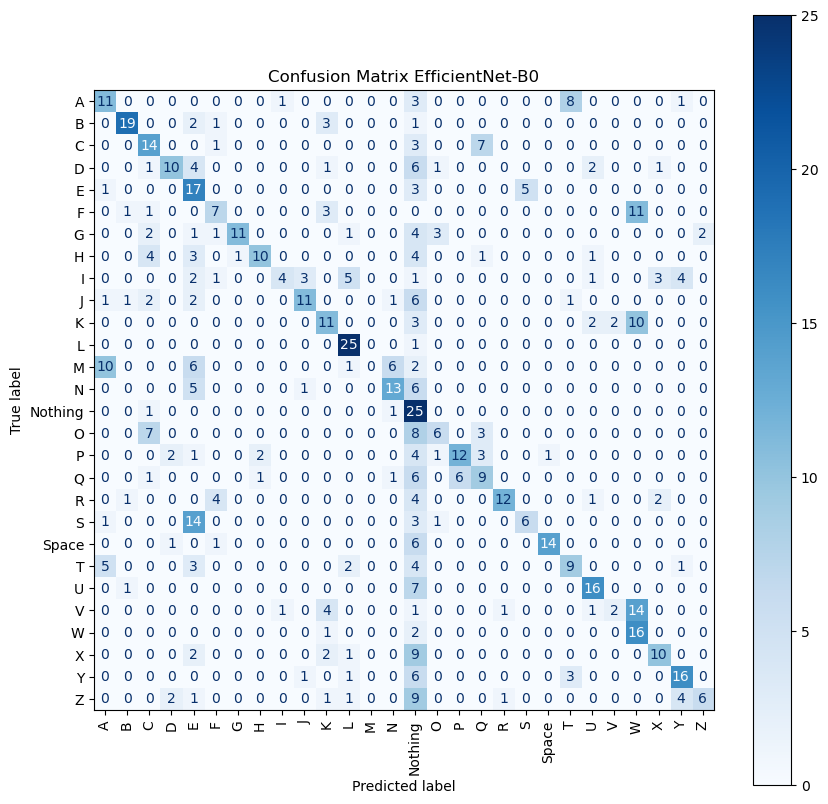

In [82]:
show_confusion_matrix(targets, predictions, title="Confusion Matrix EfficientNet-B0")

## EfficientNetV2 S

In [83]:
# Prepare the model here (will load the state-dict of the W&B artifact into this architecture when evaluating)
architecture = get_asl_efficientnet_model(get_pretrained_efficientnet_model("v2-s"), 0, 2)

The W&B artifact to load for example [such an articat](https://wandb.ai/dspro2-silent-speech/silent-speech/artifacts/model/model-tkdfqewx/v0) that is linked to a run.

In [84]:
artifact = "model-dacnc98s:v2"

In [85]:
evaluation = Evaluation("efficientnet-v2-s-eval", project=PROJECT_NAME, entity=ENTITY_NAME, model_architecture=architecture, artifact=artifact, datamodule=test_datamodule)

In [86]:
results = evaluation()

wandb: Downloading large artifact model-dacnc98s:v2, 192.04MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.9
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.49782922863960266
        test_loss           2.8274447917938232
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

epoch,▁
test_accuracy,▁
test_loss,▁
trainer/global_step,▁
epoch,0
test_accuracy,0.49783
test_loss,2.82744
trainer/global_step,0


In [87]:
predictions, targets = results

(<Figure size 1000x1000 with 2 Axes>,
 <Axes: title={'center': 'Confusion Matrix EfficientNet-V2-S'}, xlabel='Predicted label', ylabel='True label'>)

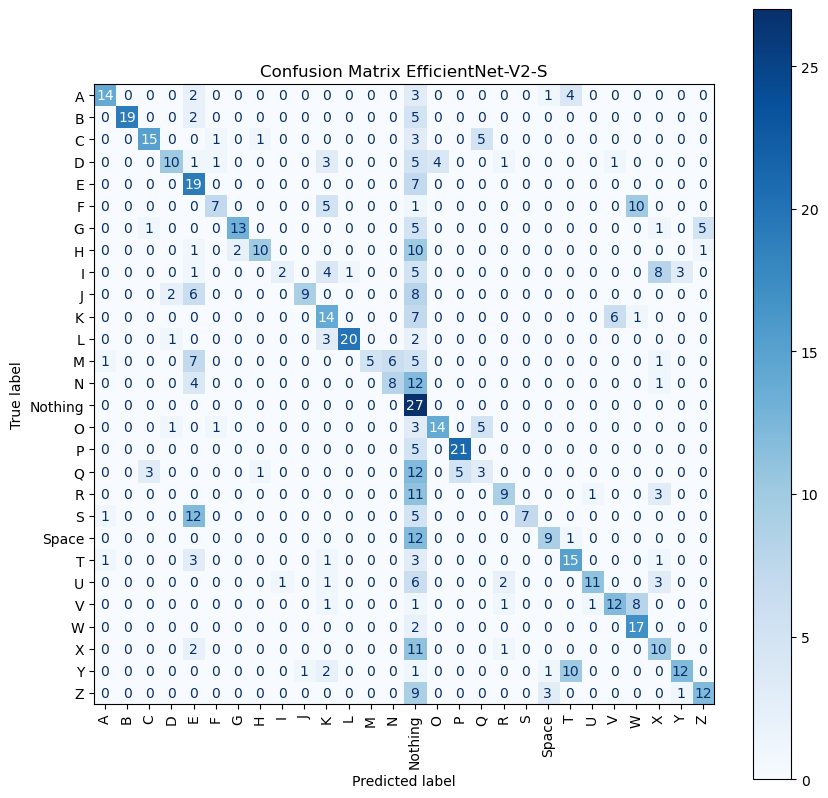

In [88]:
show_confusion_matrix(targets, predictions, title="Confusion Matrix EfficientNet-V2-S")

## EfficientNetV2 S (More BG Images)

In [89]:
# Prepare the model here (will load the state-dict of the W&B artifact into this architecture when evaluating)
architecture = get_asl_efficientnet_model(get_pretrained_efficientnet_model("v2-s"), 0, 9)

The W&B artifact to load for example [such an articat](https://wandb.ai/dspro2-silent-speech/silent-speech/artifacts/model/model-tkdfqewx/v0) that is linked to a run.

In [90]:
artifact = "model-k6r8zy9s:v1"

In [91]:
evaluation = Evaluation("efficientnet-v2-s-more-bg-eval", project=PROJECT_NAME, entity=ENTITY_NAME, model_architecture=architecture, artifact=artifact, datamodule=test_datamodule)

In [92]:
results = evaluation()

wandb: Downloading large artifact model-k6r8zy9s:v1, 192.04MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.7
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.26917511224746704
        test_loss            4.690237998962402
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

epoch,▁
test_accuracy,▁
test_loss,▁
trainer/global_step,▁
epoch,0
test_accuracy,0.26918
test_loss,4.69024
trainer/global_step,0


In [93]:
predictions, targets = results

(<Figure size 1000x1000 with 2 Axes>,
 <Axes: title={'center': 'Confusion Matrix EfficientNet-V2-S (More BG Images)'}, xlabel='Predicted label', ylabel='True label'>)

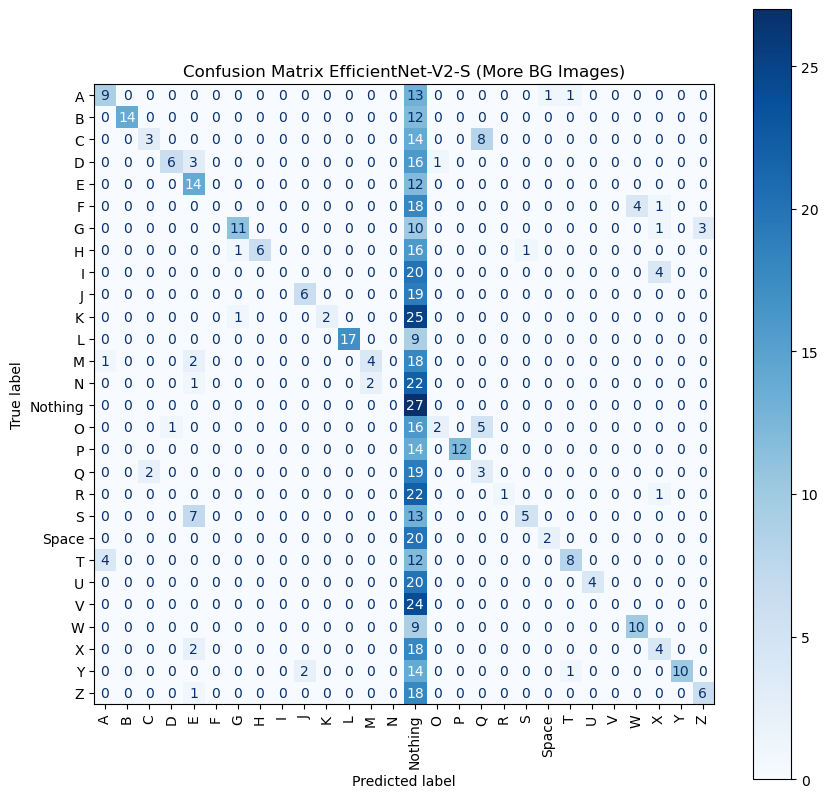

In [94]:
show_confusion_matrix(targets, predictions, title="Confusion Matrix EfficientNet-V2-S (More BG Images)")